In [37]:
# Setting up
from __future__ import print_function, division
import os
import numpy as np
import torch
import pandas as pd
from skimage import io, transform

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from training_utils import *
from data_loading import *


#transform1 = transforms.Compose([Rescale((256,256)), RandomCrop(224), ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
transform_list = transforms.Compose([grey_world(),transforms.ToPILImage(),transforms.Scale(256), transforms.RandomCrop(224), transforms.ToTensor()])#, transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

input_dir= '../datasets/'
#input_dir = '../../../mnt/nfs/work1/lspector/aks/datasets/'

train = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Training_Part3_GroundTruth.csv',
                                    root_dir=input_dir+'ISIC-2017_Training_Data/', transform=transform_list)
validation  = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Validation_Part3_GroundTruth.csv',
                                    root_dir=input_dir+'ISIC-2017_Validation_Data/', transform = transform_list)
test = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Test_v2_Part3_GroundTruth.csv',
                                    root_dir=input_dir+'ISIC-2017_Test_v2_Data/', transform = transform_list)

train_data = DataLoader(train, batch_size=8,
                        shuffle=True, num_workers=1)
val_data = DataLoader(validation, batch_size=8,
                        shuffle=True, num_workers=1)
test_data = DataLoader(test, batch_size=8,
                        shuffle=True, num_workers=1)

dataset_sizes = {'train':len(train),'val':len(validation),'test':len(test)}
print(dataset_sizes)

dataloaders = {'train':train_data,'val':val_data,'test':test_data}
%load_ext autoreload
%autoreload 2

{'test': 600, 'train': 2000, 'val': 150}
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from skimage import io, transform
image = io.imread('../datasets/ISIC-2017_Training_Data/ISIC_0000000.jpg')

image_modified = grey_world(image)


plt.imshow(image)

TypeError: object() takes no parameters

In [23]:
for i_batch, sample_batched in enumerate(test_data):
    print(i_batch, sample_batched['image'].shape[0])

    # observe 4th batch and stop.
    if i_batch == 2:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

0 8


KeyboardInterrupt: 

Process Process-7:
Traceback (most recent call last):
  File "/Users/aksaini/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


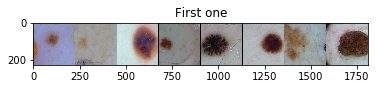

In [36]:
# visualizing some images
# Get a batch of training data
inputs = next(iter(train_data))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs['image'])

imshow(out, title="First one")

In [38]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

#print(num_ftrs)
model_conv.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, dataloaders,dataset_sizes,num_epochs=5)


Epoch 0/4
----------


In [18]:
torch.save(model_conv,'mytraining.pt')

In [19]:
mymodel = torch.load('mytraining.pt')

In [20]:
#dataloaders['test'] = dataloaders['test'][0:10]
test_model(mymodel, criterion, dataloaders,dataset_sizes)

Process Process-5:
  File "/Users/aksaini/anaconda/lib/python2.7/site-packages/skimage/io/_io.py", line 61, in imread
Traceback (most recent call last):
  File "/Users/aksaini/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/aksaini/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/aksaini/anaconda/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "data_loading.py", line 57, in __getitem__
    image = io.imread(img_name)
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
    return func(*args, **kwargs)
  File "/Users/aksaini/anaconda/lib/python2.7/site-packages/skimage/io/manage_plugins.py", line 211, in call_plugin
  File "/Users/aksaini/anaconda/lib/python2.7/site-packages/skimage/io/_plugins/pil_plugin.py", line 37, in imread


KeyboardInterrupt: 

  File "/Users/aksaini/anaconda/lib/python2.7/site-packages/skimage/io/_plugins/pil_plugin.py", line 53, in pil_to_ndarray
    im.getdata()[0]
  File "/Users/aksaini/anaconda/lib/python2.7/site-packages/PIL/Image.py", line 1153, in getdata
    self.load()
  File "/Users/aksaini/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 229, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt


In [82]:
# Actual Algorithm
#models_list = (model_conv,model_conv)
#model_data = train_meta_model(models_list, 1, dataloaders, dataset_sizes)

Training complete in 2m 33s


In [83]:
#test_meta_model(model_data, dataloaders, dataset_sizes)

test  Acc: 0.8050

Testing complete in 13m 48s


0.80500000000000005